#Google-colabt will be used for running this code, so we will start by testing that the GPU is working and comparing its speed to CPU

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
4.315912870000005
GPU (s):
0.12307622800000217
GPU speedup over CPU: 35x


Creating a directory to guide us through out the process

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


#Install YOLOv8

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package

In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

#Second method of downloading it but we won't use it
# Git clone method (for development)

# %cd {HOME}
# !git clone github.com/ultralytics/ultralytics
# %cd {HOME}/ultralytics
# !pip install -e .

# from IPython import display
# display.clear_output()

# import ultralytics
# ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/201.2 GB disk)


Import Yolo

In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

#Yolo has 2 ways methods to be used:
#1. CLI Basics
If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started.  

!yolo task=detect / classify / segment  ||  mode=train / predict / val  ||   export model=yolov8n.yaml / yolov8n-cls.yaml / yolov8n-seg.yaml / yolov8n.pt    ||  args...args...args... || format=onnx
         

yolo mode=predict runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to runs/predict.

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

/content
100% 6.23M/6.23M [00:00<00:00, 86.5MB/s]
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

100% 104k/104k [00:00<00:00, 66.1MB/s]
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 210.2ms
Speed: 13.8ms preprocess, 210.2ms inference, 1456.9ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content


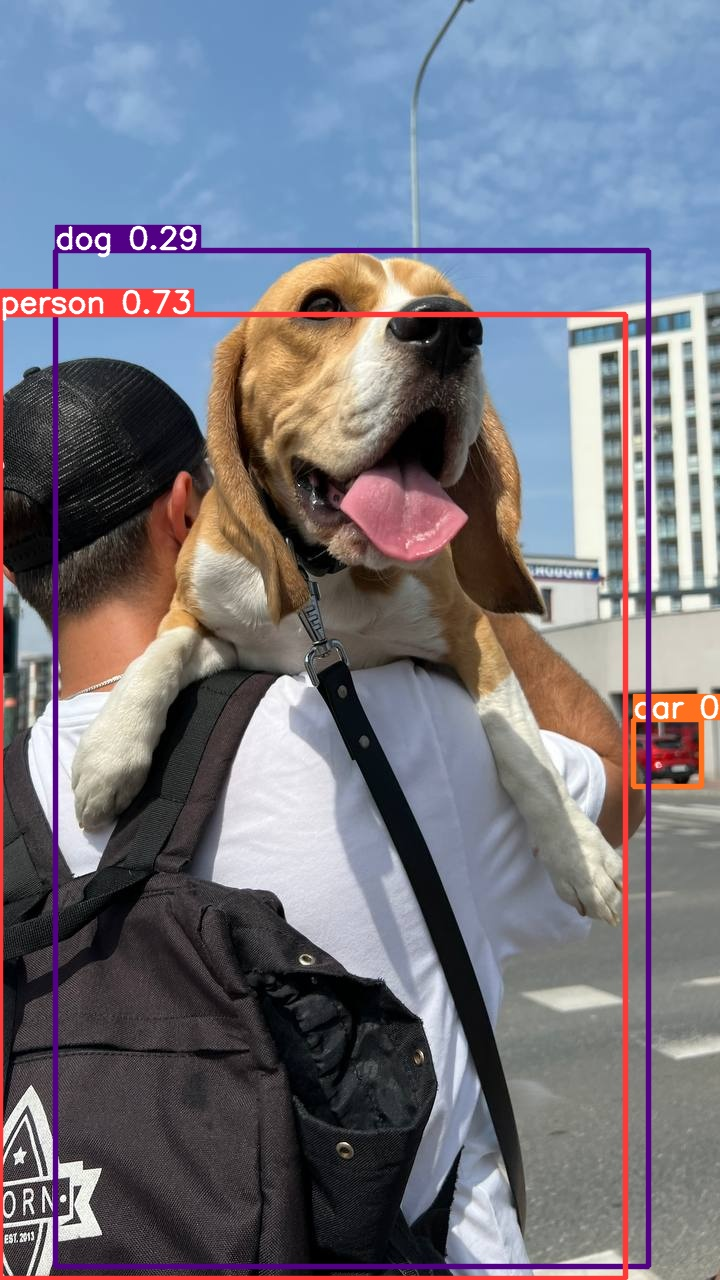

In [ ]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

# 2. Python SDK
The simplest way of simply using YOLOv8 directly in a Python environment.

In [ ]:
model = YOLO(f'{HOME}/yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 221.9ms
Speed: 4.4ms preprocess, 221.9ms inference, 993.6ms postprocess per image at shape (1, 3, 640, 384)


In [ ]:
results[0].boxes.xyxy

tensor([[   0.0000,  314.4717,  625.0754, 1278.1946],
        [  55.1731,  250.0220,  648.1080, 1266.2720],
        [ 633.2291,  719.5391,  701.0538,  786.0336]], device='cuda:0')

In [ ]:
results[0].boxes.conf

tensor([0.7271, 0.2907, 0.2846], device='cuda:0')

In [ ]:
results[0].boxes.cls

tensor([ 0., 16.,  2.], device='cuda:0')

#Exporting dataset
Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="gE66dB5HoMJrh6P7OtPT")
project = rf.workspace("mohammadjalkhatib").project("chess_dataset_topview")
version = project.version(1)
dataset = version.download("yolov8")

/content/datasets
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 961.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uni

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Chess_Dataset_TopView-1 in yolov8:: 100%|██████████| 842/842 [00:00<00:00, 2942.82it/s]


#Training the model

In [ ]:
%cd {HOME}

model = YOLO('yolov8x.yaml')  # build a new model from YAML


                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              


/content


  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

In [ ]:
results = model.train(data='/content/datasets/Chess_Dataset_TopView-1/data.yaml', epochs=75, imgsz=640)

New https://pypi.org/project/ultralytics/8.1.29 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.yaml, data=/content/datasets/Chess_Dataset_TopView-1/data.yaml, epochs=75, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualiz

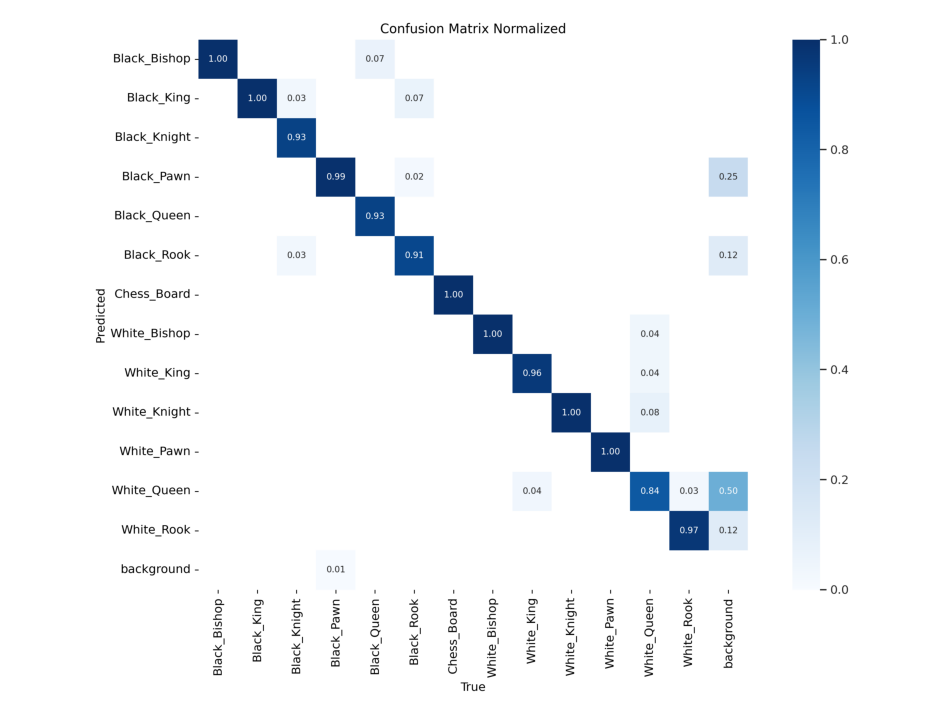

In [ ]:
#Confusion matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/runs/detect/train/confusion_matrix_normalized.png') #pred images
plt.figure(figsize=(12, 12))  # Set the figure size (8x8 inches in this example)
plt.imshow(img)
plt.axis('off')
plt.show()

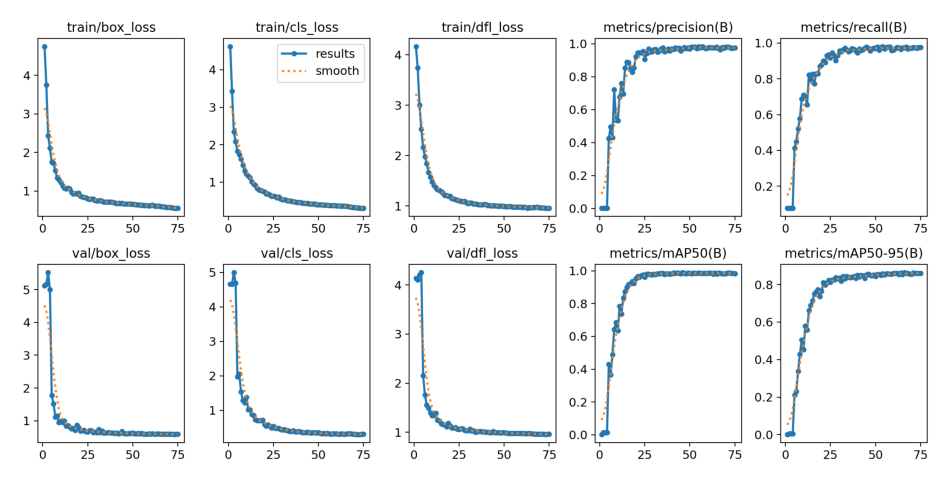

In [ ]:
#Training Results
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/runs/detect/train/results.png') #pred images
plt.figure(figsize=(12, 12))  # Set the figure size (8x8 inches in this example)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x summary (fused): 268 layers, 68136087 parameters, 0 gradients, 257.5 GFLOPs
val: Scanning /content/datasets/Chess_Dataset_TopView-1/valid/labels.cache... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]
                   all         26        614      0.971      0.974      0.987      0.864
          Black_Bishop         26         33       0.97      0.987      0.974      0.825
            Black_King         26         26      0.901          1      0.994      0.844
          Black_Knight         26         30      0.988      0.933       0.98      0.844
            Black_Pawn         26        157      0.993          1      0.995      0.843
           Black_Queen         26         15      0.985      0.933       0.98      0.855
   

array([    0.82533,     0.84375,     0.84393,      0.8432,     0.85503,     0.89634,     0.99158,     0.82787,     0.83819,     0.86346,     0.86682,     0.83184,     0.90351])

In [ ]:
validation_results = model.val(data='/content/datasets/Chess_Dataset_TopView-1/data.yaml',
                               imgsz=640,
                               batch=16,
                               conf=0.25,
                               iou=0.6,
                               device='0')

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/datasets/Chess_Dataset_TopView-1/valid/labels.cache... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
                   all         26        614      0.974      0.977      0.984      0.874
          Black_Bishop         26         33       0.97      0.997      0.974      0.847
            Black_King         26         26      0.885          1      0.994      0.856
          Black_Knight         26         30          1      0.933      0.967      0.843
            Black_Pawn         26        157      0.991          1      0.995      0.853
           Black_Queen         26         15          1      0.933      0.967      0.858
            Black_Rook         26         46      0.977      0.927      0.964      0.89

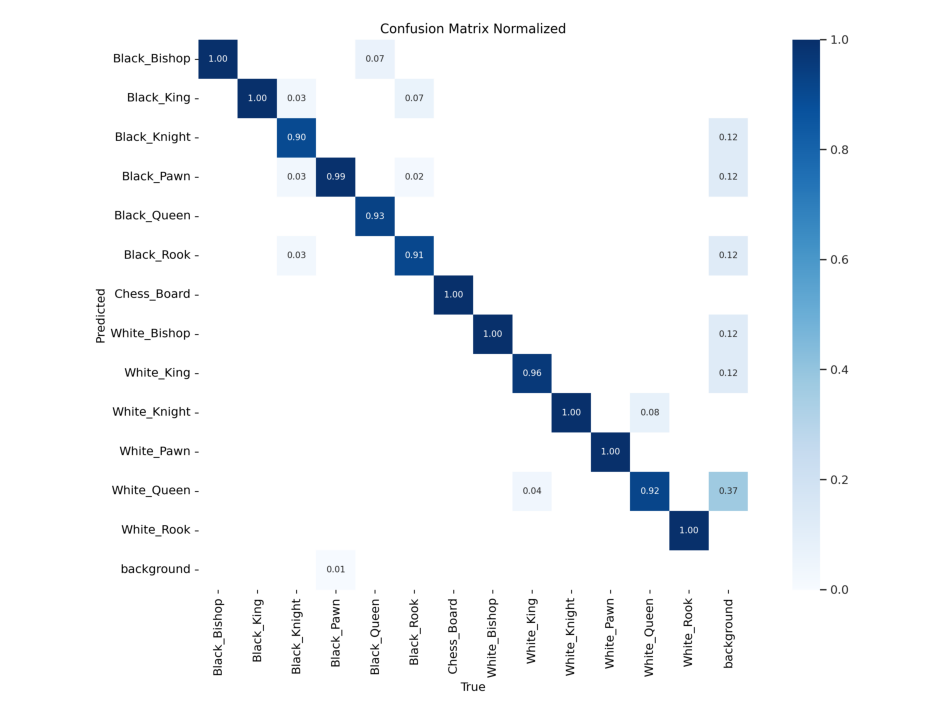

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#cofusion matrix of validation
img = mpimg.imread('/content/runs/detect/val2/confusion_matrix_normalized.png') #pred images
plt.figure(figsize=(12, 12))  # Set the figure size (8x8 inches in this example)
plt.imshow(img)
plt.axis('off')
plt.show()

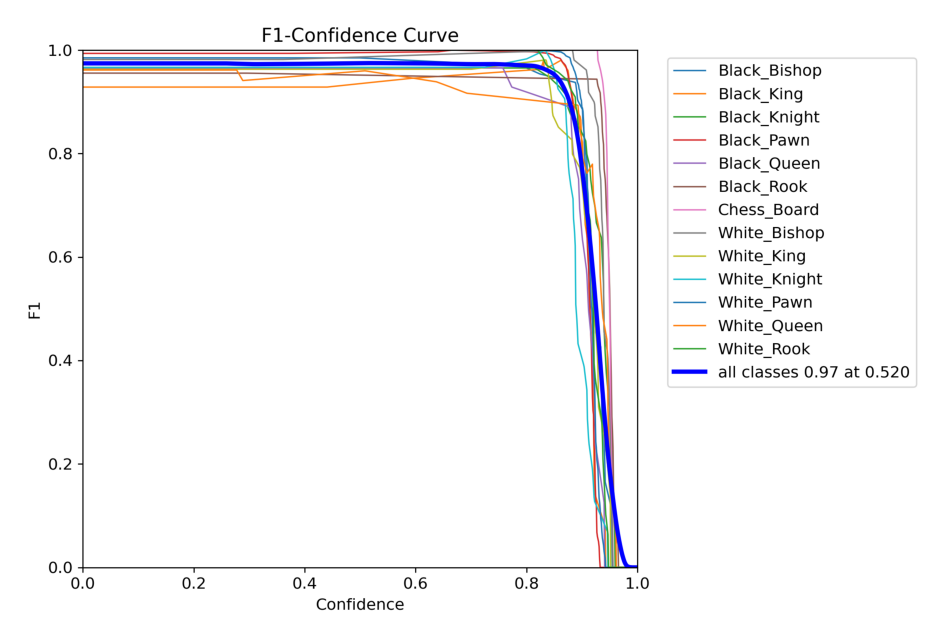

In [20]:
#F1 curve of validation
img = mpimg.imread('/content/runs/detect/val2/F1_curve.png') #pred images
plt.figure(figsize=(12, 12))  # Set the figure size (8x8 inches in this example)
plt.imshow(img)
plt.axis('off')
plt.show()

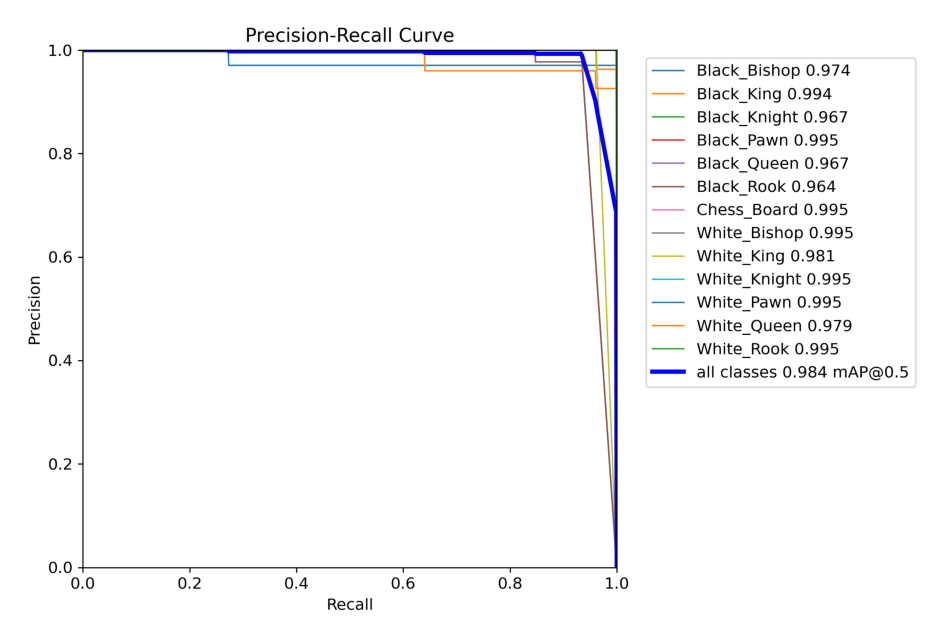

In [21]:
#PR curve of validation
img = mpimg.imread('/content/runs/detect/val2/PR_curve.png') #pred images
plt.figure(figsize=(12, 12))  # Set the figure size (8x8 inches in this example)
plt.imshow(img)
plt.axis('off')
plt.show()

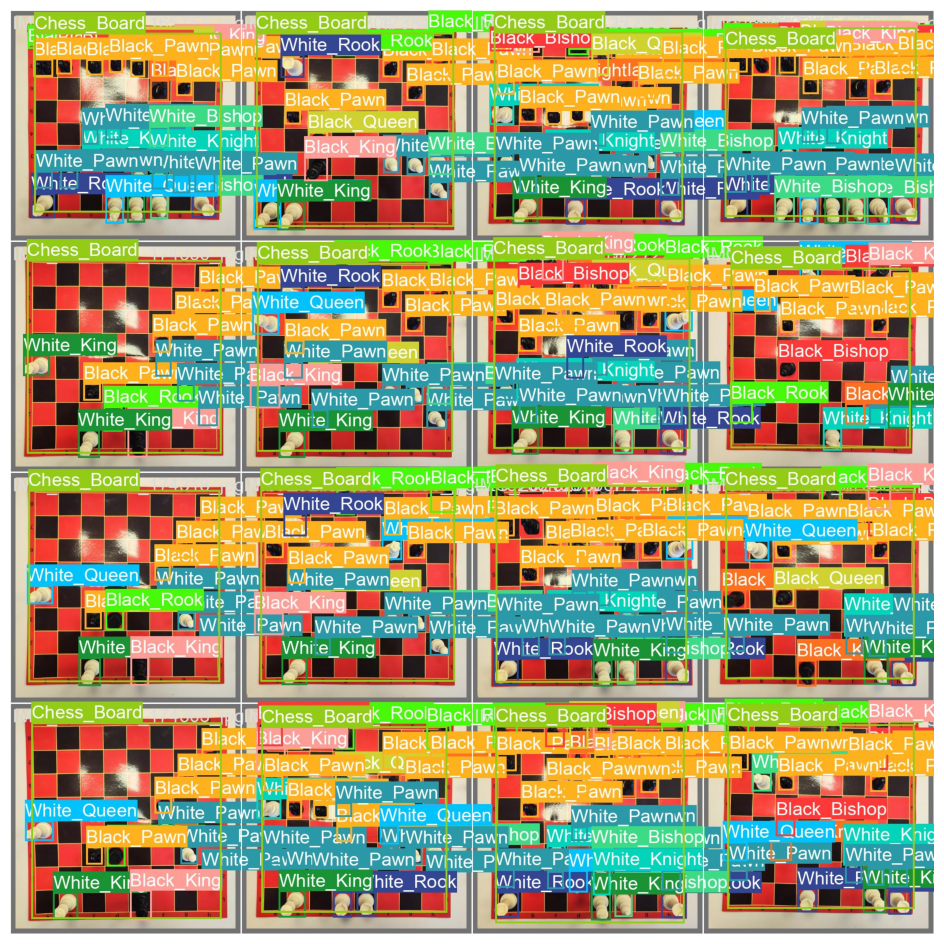

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#Original labels:
img = mpimg.imread('/content/runs/detect/val2/val_batch0_labels.jpg') #pred images
plt.figure(figsize=(12, 12))  # Set the figure size (8x8 inches in this example)
plt.imshow(img)
plt.axis('off')
plt.show()

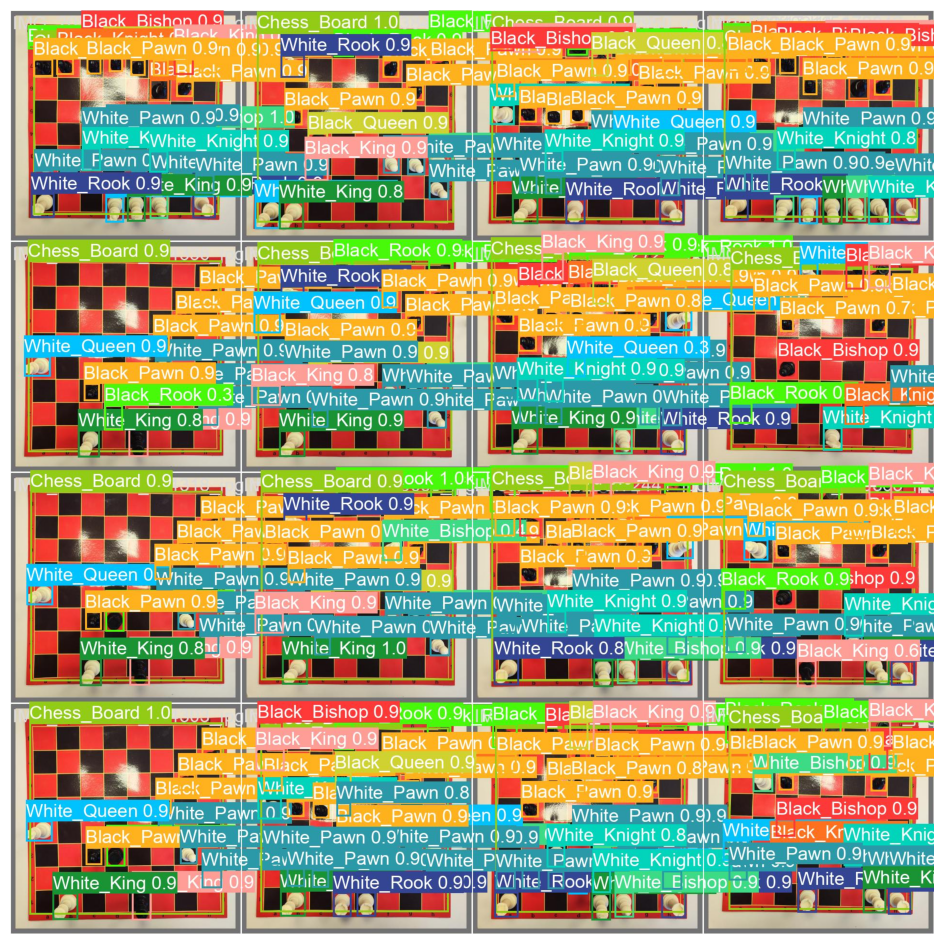

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#Predictions:
img = mpimg.imread('/content/runs/detect/val2/val_batch0_pred.jpg') #pred images
plt.figure(figsize=(12, 12))  # Set the figure size (8x8 inches in this example)
plt.imshow(img)
plt.axis('off')
plt.show()


In [24]:
# Test on images from the test images results list
results_show = model(['/content/datasets/Chess_Dataset_TopView-1/test/images/IMG_20240310_165829_jpg.rf.2d87379c4eea58f9bc06c617bd53d8d2.jpg'])  # return a list of Results objects

for result in results_show:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.plot()  # display to screen
    result.save_crop(save_dir='result.jpg')  # save to disk


0: 640x640 2 Black_Bishops, 1 Black_King, 2 Black_Knights, 7 Black_Pawns, 1 Black_Queen, 2 Black_Rooks, 1 Chess_Board, 2 White_Bishops, 1 White_King, 2 White_Knights, 7 White_Pawns, 1 White_Queen, 2 White_Rooks, 96.6ms
Speed: 2.1ms preprocess, 96.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


In [25]:
# View results
for r in results_show:
    print(r.boxes)  # print the Boxes object containing the detection bounding boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([11.,  7.,  5.,  2.,  7.,  0.,  5.,  6., 10.,  3., 10.,  8.,  3.,  3., 10., 10., 12.,  1.,  4., 10., 10.,  0.,  3.,  3., 12., 10.,  2.,  3.,  9.,  9.,  3.], device='cuda:0')
conf: tensor([0.9630, 0.9460, 0.9448, 0.9420, 0.9400, 0.9365, 0.9334, 0.9331, 0.9307, 0.9279, 0.9239, 0.9236, 0.9216, 0.9214, 0.9210, 0.9183, 0.9153, 0.9152, 0.9143, 0.9110, 0.9091, 0.9088, 0.9075, 0.9056, 0.8989, 0.8971, 0.8949, 0.8870, 0.8788, 0.8764, 0.8737], device='cuda:0')
data: tensor([[201.0664, 341.7840, 256.4134, 397.3461,   0.9630,  11.0000],
        [406.6163, 342.1700, 459.6915, 395.5487,   0.9460,   7.0000],
        [ 48.3165,  54.1064, 117.9690, 122.9591,   0.9448,   5.0000],
        [400.7959, 204.5566, 458.0222, 266.5782,   0.9420,   2.0000],
        [405.8935, 536.5507, 459.1085, 606.9788,   0.9400,   7.0000],
        [204.3108,  69.5547, 256.1598, 132.2410,   0.9365,   0.0000],
        [406.5008,  57.7774, 466.2524, 127.9975,  

In [26]:
# View Masks results
for r in results_show:
    print(r.masks)  # print the Masks object containing the detected instance masks

None


In [27]:
# View results Keypoints
for r in results_show:
    print(r.keypoints)  # print the Keypoints object containing the detected keypoints

None


In [28]:
# View Probs results
for r in results_show:
    print(r.probs)  # print the Probs object containing the detected class probabilities

None


In [29]:
# # View obb results
# for r in results_show:
#     print(r.obb)  # print the OBB object containing the oriented detection bounding boxes


0: 640x640 2 Black_Bishops, 1 Black_King, 1 Black_Knight, 7 Black_Pawns, 1 Black_Queen, 2 Black_Rooks, 1 Chess_Board, 2 White_Bishops, 1 White_King, 1 White_Knight, 7 White_Pawns, 1 White_Queen, 2 White_Rooks, 1: 640x640 2 Black_Bishops, 1 Black_King, 1 Black_Knight, 6 Black_Pawns, 1 Black_Queen, 2 Black_Rooks, 1 Chess_Board, 2 White_Bishops, 1 White_King, 1 White_Knight, 5 White_Pawns, 1 White_Queen, 2 White_Rooks, 190.0ms
Speed: 1.6ms preprocess, 95.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


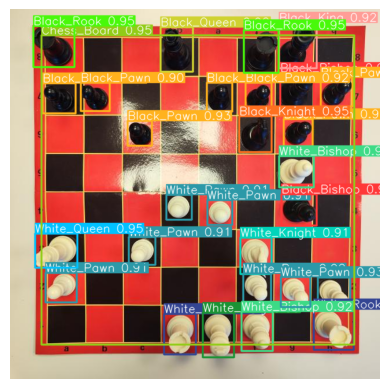

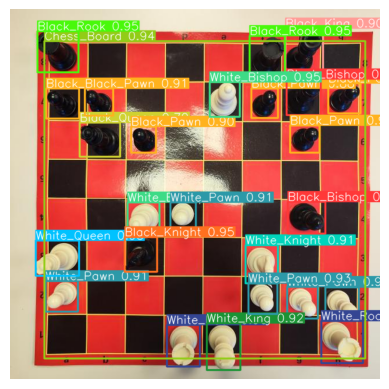

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

# Load 2 images out of the test patch to test the system
results = model(['/content/datasets/Chess_Dataset_TopView-1/test/images/IMG_20240310_170017_jpg.rf.70cd751ddf410ae2923ea605b6270b14.jpg', '/content/datasets/Chess_Dataset_TopView-1/test/images/IMG_20240310_170056_jpg.rf.7eae12cfd1e72beeb4675e0fc7c01b5f.jpg'])  # results list

# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Display the results using matplotlib
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()

    # # Save results to disk
    # r.save(filename=f'results{i}.jpg')


#Export Trained Model

In [ ]:
#Export the model
model = YOLO('/content/runs/detect/train/weights/best.pt')  # load a custom trained model

# Export the model
model.export(format='onnx')


#Benchmark

In [31]:
# from ultralytics.utils.benchmarks import benchmark

# # Benchmark on GPU
# benchmark(model=model, data='/content/datasets/Chess_Dataset_TopView-1/data.yaml', imgsz=640, half=False, device=0)

#Trying to transfer it into FEN notations

In [32]:
def convert_to_fen(labels, bounding_boxes):
    # Initialize an empty chessboard
    board = [[' '] * 8 for _ in range(8)]

    # Place pieces on the board based on detected bounding boxes and labels
    for label, (x, y, width, height) in zip(labels, bounding_boxes):
        piece = label.split('_')[1]
        color = label.split('_')[0]

        # Map coordinates to board indices
        rank = 7 - int(y * 8) // 416
        file = int(x * 8) // 416

        # Place piece on the board
        if color == 'White':
            board[rank][file] = piece.upper()
        else:
            board[rank][file] = piece.lower()

    # Convert board state to FEN notation
    fen_board = '/'.join([''.join(row) for row in board])
    fen = fen_board + ' w - - 0 1'  # Assuming default values for the rest

    return fen

# Example usage:
# Assuming you have lists of labels and bounding boxes from your predictions
# Replace these with your actual lists of labels and bounding boxes
predicted_labels = ['Chess_Board', 'White_Pawn', 'Black_Rook']
predicted_boxes = [(0.1, 0.2, 0.1, 0.1), (0.3, 0.4, 0.1, 0.1), (0.6, 0.7, 0.1, 0.1)]

# Convert predicted labels and bounding boxes to FEN notation
fen = convert_to_fen(predicted_labels, predicted_boxes)
print("FEN notation:", fen)


FEN notation:         /        /        /        /        /        /        /rook        w - - 0 1


In [33]:
# !pip install ultralytics==8.0.196


In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Initialize YOLO model
yolo = YOLO('/content/runs/detect/train/weights/best.pt')

# Load image
image = cv2.imread("/content/datasets/Chess_Dataset_TopView-1/test/images/IMG_20240310_170056_jpg.rf.7eae12cfd1e72beeb4675e0fc7c01b5f.jpg")

# Perform object detection
predictions = yolo.predict(source='/content/datasets/Chess_Dataset_TopView-1/test/images/IMG_20240310_170109_jpg.rf.30409e2e6fe49e28d33cd399b41b7cfa.jpg', conf=0.25)


# Extract boxes and classes from predictions
boxes = [pred[0] for pred in predictions]
classes = [pred[1] for pred in predictions]



# Define the order of FEN notation from the top-left corner
fen_order = [
    (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7),
    (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7),
    (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7),
    (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7),
    (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7),
    (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7),
    (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)
]

# Generate FEN notation from detected pieces
def generate_fen(predictions):
    fen = ""
    piece_mapping = {
        1: "K", 2: "Q", 3: "B", 4: "N", 5: "R", 6: "P",
        7: "k", 8: "q", 9: "b", 10: "n", 11: "r", 12: "p",
        0: ""  # Chess board class (ignore)
    }
    board_state = [[""] * 8 for _ in range(8)]
    for pred in predictions:
        x_min, y_min, x_max, y_max, class_id, _ = pred  # Unpack the prediction values
        piece = piece_mapping[class_id]
        if piece:
            # Find the grid index from the YOLO bounding box
            center_x = (x_min + x_max) / 2
            center_y = (y_min + y_max) / 2
            col = int(center_x // (image.shape[1] / 8))
            row = int(center_y // (image.shape[0] / 8))
            # Update board state
            board_state[row][col] = piece
    # Construct FEN notation
    for row, col in fen_order:
        piece = board_state[row][col]
        if not piece:
            empty_count = 0
            for col_offset in range(1, 8 - col):
                if not board_state[row][col + col_offset]:
                    empty_count += 1
                else:
                    break
            if empty_count > 0:
                fen += str(empty_count)
        else:
            fen += piece
    return fen

# Convert detected objects to FEN notation
fen_notation = generate_fen(predictions)
print("FEN notation:", fen_notation)

# Release resources
yolo.close_session()


image 1/1 /content/datasets/Chess_Dataset_TopView-1/test/images/IMG_20240310_170109_jpg.rf.30409e2e6fe49e28d33cd399b41b7cfa.jpg: 640x640 2 Black_Bishops, 1 Black_King, 2 Black_Knights, 6 Black_Pawns, 1 Black_Queen, 2 Black_Rooks, 1 Chess_Board, 2 White_Bishops, 1 White_King, 1 White_Knight, 5 White_Pawns, 1 White_Queen, 2 White_Rooks, 96.7ms
Speed: 4.3ms preprocess, 96.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)


ValueError: too many values to unpack (expected 6)

In [42]:
predictions

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Black_Bishop', 1: 'Black_King', 2: 'Black_Knight', 3: 'Black_Pawn', 4: 'Black_Queen', 5: 'Black_Rook', 6: 'Chess_Board', 7: 'White_Bishop', 8: 'White_King', 9: 'White_Knight', 10: 'White_Pawn', 11: 'White_Queen', 12: 'White_Rook'}
 orig_img: array([[[178, 208, 219],
         [178, 208, 219],
         [178, 208, 219],
         ...,
         [202, 222, 233],
         [202, 222, 233],
         [202, 222, 233]],
 
        [[178, 208, 219],
         [178, 208, 219],
         [178, 208, 219],
         ...,
         [202, 222, 233],
         [202, 222, 233],
         [202, 222, 233]],
 
        [[178, 208, 219],
         [178, 208, 219],
         [178, 208, 219],
         ...,
         [202, 222, 233],
         [202, 222, 233],
         [202, 222, 233]],
 
        ...,
 
        [[166, 200, 213],
         [166, 200, 213],
         [166, 200, 